In [1]:
import cv2
import numpy as np
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from dotenv import load_dotenv
 
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [2]:
import sys
sys.path.append('/Users/daniel/OAN/SID/')

In [3]:
import sid_modules.helperFunctions as hf

In [4]:
conn = sqlite3.connect("casas.sqlite")

In [26]:
tables = pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"',conn)
tables

name
0   Sansi Gando
1  Besen Gourou
2      Barkedje
3        Boudal
4        Monnon

In [12]:
t1 = tables['name'][4]
t1

'Monnon'

In [13]:
df = pd.read_sql('SELECT * FROM `{}`'.format(t1),conn)

In [14]:
df['houses'] = df['houses'].apply(eval)

In [15]:
df

index                                             houses   type village  \
0      0  [[1393, 874], [1385, 923], [1409, 926], [1417,...  metal  Monnon   
1      1   [[859, 276], [859, 311], [969, 311], [967, 276]]  metal  Monnon   
2      2  [[1500, 845], [1492, 857], [1493, 891], [1514,...  round  Monnon   

  size  
0    5  
1    5  
2    5

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    125 non-null    int64 
 1   houses   125 non-null    object
 2   type     125 non-null    object
 3   village  125 non-null    object
 4   size     125 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.0+ KB


In [8]:
image_name = t1+"_5_19_500.png"

In [9]:
im = cv2.imread(image_name,cv2.COLOR_BGR2RGB)

In [59]:
houses = df.T.to_dict()
for i in houses:
    row = houses[i]
    house = row['houses']
    ttype = row['type']
    if ttype == 'metal':
        vertices = np.array(house,dtype=np.int32)
        pts = vertices.reshape((-1,1,2))
        cv2.polylines(im,[pts],isClosed=True,color=(0,0,255),thickness=5)
    if ttype == 'round':
        vertices = np.array(house,dtype=np.int32)
        pts = vertices.reshape((-1,1,2))
        cv2.polylines(im,[pts],isClosed=True,color=(0,255,0),thickness=5)


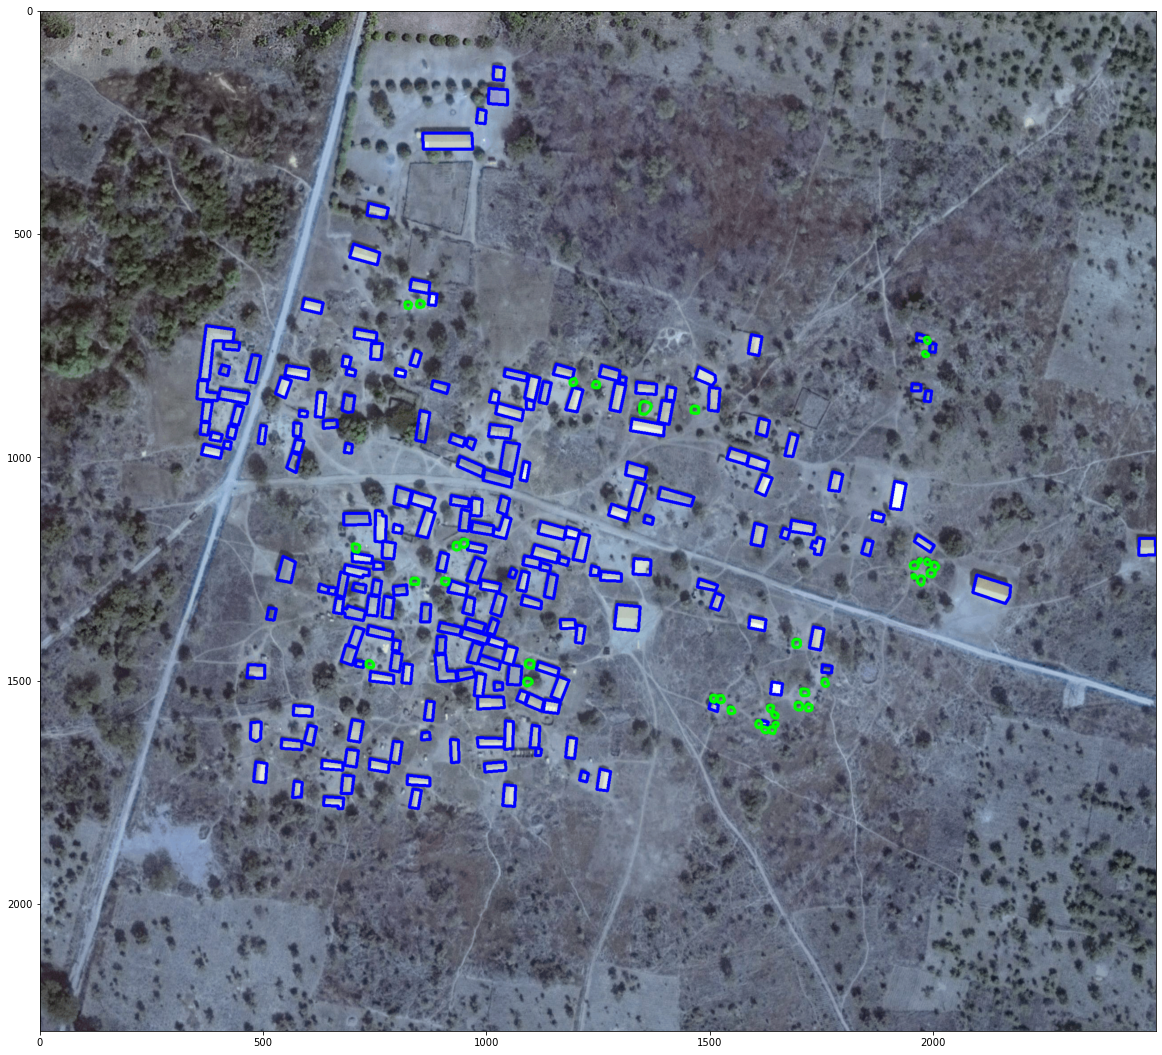

In [60]:
fig = plt.figure(figsize=(20,20))
plt.imshow(im)

## UPLOAD TO BIGQUERY

In [24]:
hf.SIDBuilding()

In [26]:
"""
district (str): district it belongs to [Biro, Nikki] 
    village (str): village it belongs to 

    analysis_method (str): analysis detection method [ml,edge,color]

    lat (float): lat in deg from the center
    lon (float): lon in deg from  the center

    perim (float): perimeter in km  
    area (float): area in km2

    boundary_lat(str): list of lat coords from the boundary
    boundary_lon(str): list of lon coords from the boundary

    polygon (Polygon): Polygon of the shape
    point (Point): Point in the center
"""


'\ndistrict (str): district it belongs to [Biro, Nikki] \n    village (str): village it belongs to \n\n    analysis_method (str): analysis detection method [ml,edge,color]\n\n    lat (float): lat in deg from the center\n    lon (float): lon in deg from  the center\n\n    perim (float): perimeter in km  \n    area (float): area in km2\n\n    boundary_lat(str): list of lat coords from the boundary\n    boundary_lon(str): list of lon coords from the boundary\n\n    polygon (Polygon): Polygon of the shape\n    point (Point): Point in the center\n'

In [10]:
df = pd.DataFrame()

In [11]:
for table in tables['name']:
    print(table)
    df_vil = pd.read_sql('SELECT * FROM `{}`'.format(table),conn)
    df= df.append(df_vil)

Sansi Gando
Monnon
Besen Gourou
Barkedje
Boudal


In [12]:
df = df[['houses','type','village']].copy()

In [27]:
trad_im = {
    'Sansi Gando':
    {'im':'Sansi Gando_5_19_500.png',
    'district':'Biro'},
    'Monnon':{'im':'Monnon_5_19_500.png',
    'district':'Nikki'},
    'Besen Gourou':{'im':'Besen Gourou_5_19_500.png',
    'district':'Biro'},
    'Barkedje':{'im':'Barkedje_5_19_500.png',
    'district':'Nikki'},
    'Boudal':{'im':'Boudal_5_19_500.png',
    'district':'Nikki'}
    
}

In [28]:
df['image'] = df['village'].apply(lambda x: trad_im[x]['im'])

In [29]:
df['district'] = df['village'].apply(lambda x: trad_im[x]['district'])

In [30]:
df['analysis_method'] = 'manual'

In [31]:
df['houses'] = df['houses'].apply(eval)

In [32]:
df['lat'] = df['houses'].apply(lambda x: np.mean([a[0] for a in x]))

In [34]:
df['lon'] = df['houses'].apply(lambda x: np.mean([a[1] for a in x]))

In [35]:
df['boundary_lat'] = df['houses'].apply(lambda x: str([a[0] for a in x]))

In [36]:
df['boundary_lon'] = df['houses'].apply(lambda x: str([a[1] for a in x]))

In [37]:
df['perim'] = 0

In [38]:
df['area'] = 0

In [39]:
df.to_gbq(
    'output_data.poc_buildings_from_labeled',
    project_id='sidhouses',
    if_exists='replace')

1it [00:02,  2.65s/it]


### CONVERT TO PIXELS

In [29]:
bqh = hf.BigQueryHelper()

In [30]:
im_metadata = bqh.loadImages()

Downloading: 100%|██████████| 5/5 [00:00<00:00, 28.62rows/s]


In [31]:
im_metadata

img_name          name  input_lat  input_lon  input_size  \
0        Monnon_5_19_500.png        Monnon   9.842513   3.178864         500   
1   Sansi Gando_5_19_500.png   Sansi Gando   9.947919   3.418565         500   
2  Besen Gourou_5_19_500.png  Besen Gourou   9.905893   3.350370         500   
3      Barkedje_5_19_500.png      Barkedje  10.025566   3.287887         500   
4        Boudal_5_19_500.png        Boudal   9.866730   3.172789         500   

   grid_size  zoom  lat_size  lon_size      lat_0     lon_0  m_per_px_lat  \
0          5    19      2285      2500   9.845532  3.175517      0.294187   
1          5    19      2285      2500   9.950937  3.415034      0.294093   
2          5    19      2285      2500   9.908911  3.346920      0.294131   
3          5    19      2285      2500  10.028584  3.284179      0.294023   
4          5    19      2285      2500   9.869749  3.169404      0.294166   

   m_per_px_lon  deg_per_m_lat  deg_per_m_lon  deg_per_px_lat  deg_per_px_lon  
0      0.298123       0.000008       0.000009        0.000002        0.000003  
1      0.298051       0.000008       0.000009        0.000002        0.000003  
2      0.298072       0.000008       0.000009        0.000002        0.000003  
3      0.298091       0.000008       0.000010        0.000002        0.000003  
4      0.298124       0.000008       0.000009        0.000002        0.000003

In [35]:
ch = hf.ConversionHelper()

In [476]:
df = pd.read_gbq('SELECT * from output_data.poc_buildings_from_labeled')

In [477]:
df['houses'] = df['houses'].apply(eval)

### COMPROBACION

In [457]:
n=100
vill = 'Barkedje'

In [458]:
df[df['village']==vill].shape

(125, 12)

In [459]:
print(df[df['village']==vill].iloc[n]['houses'])

[[1175, 1334], [1166, 1333], [1164, 1335], [1162, 1340], [1161, 1344], [1164, 1348], [1166, 1349], [1169, 1350], [1172, 1350], [1175, 1348], [1176, 1345]]


In [460]:
lat = int(df[df['village']==vill].iloc[n]['lat'])
lon = int(df[df['village']==vill].iloc[n]['lon'])

In [461]:
vil_im = cv2.imread('/Users/daniel/OAN/SID/poc/'+vill+'_5_19_500.png')

In [462]:
vertices = np.array(df[df['village']==vill].iloc[n]['houses'],dtype=np.int32)
pts = vertices.reshape((-1,1,2))
a=cv2.polylines(vil_im,[pts],isClosed=True,color=(0,0,255),thickness=5)

In [464]:
a = cv2.circle(img=vil_im,
           center=(lat,lon),
           radius=5,
           color=(255,0,0),
           thickness=-1)

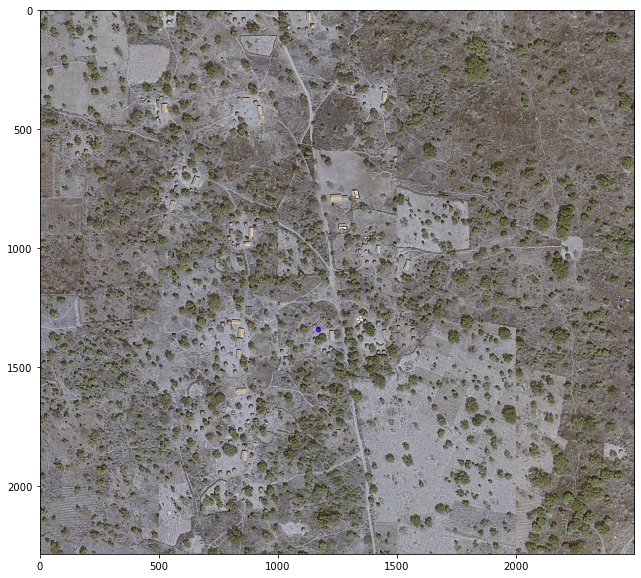

In [465]:
plt.figure(figsize=(20,10))
plt.imshow(vil_im)

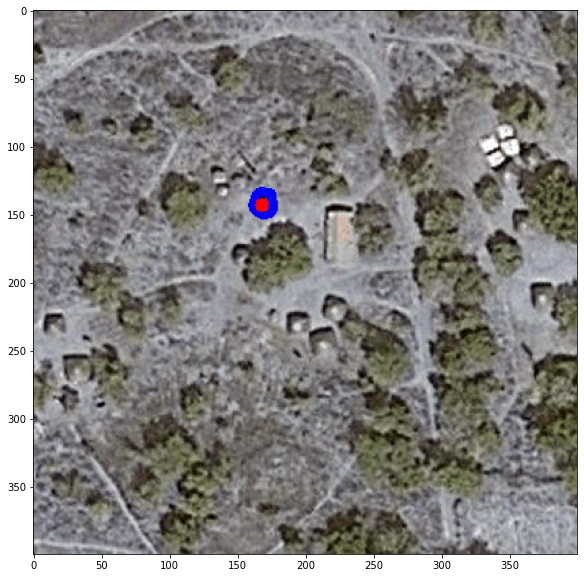

In [467]:
plt.figure(figsize=(20,10))
plt.imshow(vil_im[1200:1600,1000:1400])

In [468]:
def point_px_to_deg_2(lat: int, lon: int, row_ref: pd.DataFrame) -> (float, float):
    """Transforms coords in px to lat,lon in deg

    Args:
        lat (int): latitud in Pixels
        lon (int): longitud in Pixels
        row_ref (DataFrame): DataFrame Row from the corresponding image

     Returns:
        lat_deg (float): latitud in Deg
        lon_deg (float): longitud in Deg
    """

    deg_per_px_lat = row_ref['deg_per_px_lat']
    deg_per_px_lon = row_ref['deg_per_px_lon']
    lat_deg = row_ref['lat_0'] - lat * deg_per_px_lat/0.93
    lon_deg = row_ref['lon_0'] + lon * deg_per_px_lon

    return lat_deg, lon_deg

In [470]:
lat, lon = point_px_to_deg_2(df[df['village']==vill].iloc[n]['lon'],
                   df[df['village']==vill].iloc[n]['lat'],
                  im_metadata[im_metadata['name']==vill].iloc[0])

In [471]:
lat

10.025096773303757

In [370]:
(9.841677473614752, 3.1775666427033826)

(9.841677473614752, 3.1775666427033826)

In [324]:
im_metadata.iloc[4]['input_size']

500

In [325]:
im_metadata.iloc[4]['deg_per_px_lat']

2.41526726287635e-06

### CONVERTIR LAT LON

In [484]:
df = pd.read_gbq('SELECT * from output_data.poc_buildings_from_labeled')

In [485]:
df['houses'] = df['houses'].apply(eval)

In [486]:
df['lat_pixel'] = df['lat'] # df['lon']
df['lon_pixel'] = df['lon'] # df['lat']

In [487]:
def get_latlon(x):
    lat,lon = point_px_to_deg_2(x['lon_pixel'],
                   x['lat_pixel'],
                  im_metadata[im_metadata['name']==x['village']].iloc[0])
    
    return pd.Series([lat, lon])

In [488]:
df[['lat','lon']] = df.apply(lambda x: get_latlon(x),axis = 1)

In [489]:
df['boundary_lat'] = df['houses'].apply(lambda x: str([a[1] for a in x]))

In [490]:
df['boundary_lon'] = df['houses'].apply(lambda x: str([a[0] for a in x]))

In [491]:
df['perim'] = 0

In [492]:
df['area'] = 0

In [493]:
df.to_gbq(
    'output_data.poc_buildings_from_labeled',
    project_id='sidhouses',
    if_exists='replace')

1it [00:02,  2.63s/it]
